# ADAMS Tutorial #4: Neural Networking (NN) Primer
## Part 2 of 3
This is the second of three notebooks which will cover the foundations of neural networks. Recall that every connection in a neural network carries a weight. Therefore, calculating the *forward pass* requires concrete values for these weights. In the first notebook, we discussed how the weights can be initialized randomly. The focus of this notebook is network training. Training is the process in which we update the weights to maximize the fit of our network to (the training) data. Network training is, therefore, equivalent to maximum likelihood estimation in regression analysis. 

## This notebook's topic: back propagation in neural networks ##
 1. Overview of the forward pass
 2. Caculating loss
 2. Finding a minimum
 3. Moving towards a minimum
 4. One solver for gradient descent: Stochastic gradient descent
 5. Stopping Rules
 6. Overview of back propagation

In [1]:
# Import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import random

np.random.seed(888)  # set seed for reproducibility (numPy functions)
random.seed(888)  # set seed for reproducibility (random package functions)

range_for_demo = np.linspace(-5, 5, 100)

In [2]:
# Generate regression dataset
from sklearn.datasets import make_regression

n = 1000  # number of observations in our simulation
k = 15    # number of features in X in our simulation

XX, Y = make_regression(n_samples=n, n_features=k, noise=5, random_state=888)

Y = Y.reshape(n, 1)  # Make sure that y is an array

To start, we revisit the forward pass through a neural network. Here, we simply go through the corresponding code. The first part of this series of notebooks explains the steps in detail. 

In [3]:
# Network architecture:
inputLayer_size = k      # number of features in X
hiddenLayer_size = 10    # number of hidden layer nodes
outputLayer_size = 1     # number of values to predict

In [4]:
# Weight initialization for first forward pass

limit = np.sqrt(6 / (inputLayer_size + outputLayer_size))  # Recommended weight initialization

W_0 = np.random.uniform(-limit, limit, (hiddenLayer_size, inputLayer_size))    # Random weight initialization
W_1 = np.random.uniform(-limit, limit, (outputLayer_size, hiddenLayer_size))  # Random weight initialization

B_0  = np.ones((hiddenLayer_size,1))  # Bias initialization
B_1 = np.ones((outputLayer_size,1))  # Bias initialization

In [5]:
# Activation function that we will use in this scenario and its derivative
def ReLU(x):
    return np.maximum(0, x)  # 0 if input is negative, x if input is positive


def ReLU_derivative(x):
    return (x > 0)*1.0

In [6]:
# First forward pass
X = np.array(XX[5]).reshape((inputLayer_size, 1))  # observation 5
y = Y[5].reshape((outputLayer_size, 1))  # true value of target
Z_hidden = np.dot(W_0, X) + B_0  # first hidden layer inputs
H = ReLU(Z_hidden)  # hidden layer output (after activation)
Z_output = np.dot(W_1, H) + B_1  # input to output layer
y_hat = Z_output  # Here, we will use a linear activation, so the output layer input is already the prediction! You could replace this with another activation
y_hat.shape  # shape of first forward pass predictions

(1, 1)

Let's compare the loss and target for this observation. We can see that the random weight initialization is pretty far off.

In [7]:
print(y_hat, y)

[[-1.45032451]] [[207.75432522]]


# Back Propagation

## Motivation:
With a set of random weights, would a prediction be any good? Probably not. However, the magic of neural networks comes from the method to update the complex system of weights. This is known as back propagation or backprop for short. 

## Calculating loss
The first step in back propagation is to calculate the loss. Recall that *loss* is just another term for error. Several measures facilitate calculating the loss of a regression model. Well-known candidates include mean square error, root-mean square error, mean absolute error, and many others. In general, a loss function measures the degree to which the outputs of your model (i.e., neural network) fit the training data. Higher losses indicate a poorer fit. Thus, after computing the loss, we want to minimize it. This minimization is what network training is about. 
<br>
For illustration, we consider the mean square error (MSE) in the following.

In [8]:
# mean squared error
def mse(true, pred):
    sse = 0
    for i in range(len(true)):
        sse += (true[i] - pred[i])**2
    mse = (1 / 2*len(true)) * np.sum(sse)
    return mse

For now, let's calculate the loss from our first model:

In [9]:
loss = mse(y, y_hat)
loss

21883.29273423478

## Finding a minimum
Like a linear regression, we are working with input values along with layers of weights and a biases (= intercepts in the regression). Our loss function is a function of these three elements. Of these three elements, weights and bias are what we can adjust. So, let’s derive our loss function based on those. We will focus on deriving with respect to weights here, but the process for biases is similar.

$$\begin{aligned}
&\frac{\partial MSE }{\partial w_j} = \frac{\partial}{\partial w_j} \frac{1}{2n} \sum_{i=1}^n (\hat y - y)^2\\
&\frac{\partial MSE }{\partial w_j} = \frac{1}{2n} \sum_{i=1}^n \frac{\partial}{\partial w_j}  (\hat y - y)^2\\
&\frac{\partial MSE }{\partial w_j} = \frac{1}{2n} \sum_{i=1}^n 2(\hat y - y) \cdot \frac{\partial}{\partial w_j}(\hat y - y)\\
\end{aligned}$$

Now at this point, we know that the true $y$ is just a scalar. So its derivative is 0. What is the derivative of $\hat y$ w.r.t. $w_j$? Well, recall the function of $\hat y$ :

$$\hat y=w_{0}+w_{1}x_{1}+w_{2}x_{2}+...+w_{k}x_{k}$$ 

So, the derivative w.r.t. to a single $w_j$ will just be the corresponding $x$ value.

$$\begin{aligned}
& \frac{\partial MSE }{\partial w_j} = \frac{2}{2n} \sum_{i=1}^n (\hat y - y) \cdot \frac{\partial \hat y}{\partial w_j}\\
&\frac{\partial MSE }{\partial w_j} = \frac{1}{n} \sum_{i=1}^n (\hat y - y) \cdot x \\
\end{aligned}$$

note that if $ w_0 $ is the intercept, we would set $ x=1 $.

Consider: Our loss function is a function of the true value and our NN’s output. Our NN’s output is a function of the last nodes’ outputs. Our last nodes’ outputs are all a function of their own input values, weights and biases. We’re lucky that we can simply use the chain rule to calculate the derivatives for each parameter! We will then have to organize our derivatives into gradients which are vectors of derivatives of different variables from the same function. For full optimization, we will need to calculate this derivative for every observation as well. We will discuss a simplification technique for this called stochastic gradient descent later.

So for each observation, we have to calculate: 

$$ \Bigg[ \frac{\partial MSE }{\partial w_0},  \frac{\partial MSE }{\partial w_1}, \frac{\partial MSE }{\partial w_2}, ... ,  \frac{\partial MSE }{\partial w_k} \Bigg] $$

In [10]:
def mse_derivative(true, pred, x):
    n = len(x)
    loss_d = (1/n) * np.sum((pred-true)*x)
    return loss_d.reshape(1, 1)

In [11]:
loss_derivative = mse_derivative(Y[5], y_hat, XX[5])  # loss derivative
loss_derivative

array([[-35.22604501]])

In [12]:
activation_derivative = 1  # activation derivative, if the final activation is f(x) = x, then its derivative is 1
activation_derivative

1

Remember that the output layer's output is a function of the following:
- the output layer's inputs
- the hidden layer's outputs
- the hidden layer's inputs
- the original X values

We will need to update all weights connecting these together.

In [13]:
# Update weights furthest back in the network (between hidden and output layer)
gradient_HiddenToOutput = np.dot(loss_derivative*activation_derivative, np.transpose(H))
gradient_HiddenToOutput.shape

# Update output layer biases
gradient_HiddenToOutput_bias = loss_derivative*activation_derivative

# Save the error of the output layer
pred_errors = loss_derivative * activation_derivative

# Find gradient for next step for backpropagation: gradient to update weights between hidden and input layer
gradient_InputToHidden = np.dot(W_1.T, pred_errors)
print(f'Shape of first weights {W_1.shape}')

# Next propagation backwards: derivative of the hidden layer output wrt the hidden layer input (ReLU derivative)
gradient_InputToHidden = gradient_InputToHidden * ReLU_derivative(Z_hidden)
print(f'Shape of gradient vector {gradient_InputToHidden.shape}')

# Derivate of the hidden layer input wrt to the weight matrix connecting the hidden layer to inputs X
gradient_InputToHidden = np.dot(gradient_InputToHidden, np.transpose(X))
print(f'Shape of input {X.shape}')

# Last update: output layer biases
gradient_InputToHidden_bias = np.dot(W_1.T, pred_errors) * ReLU_derivative(Z_hidden)

Shape of first weights (1, 10)
Shape of gradient vector (10, 1)
Shape of input (15, 1)


## Moving towards a minimum
We could update all weights by trying to take a large step down the gradient. However, since there are so many combinations of weights and bias, this just reach one local minimum of many, or it may overshoot the local minimum. It could be that there is a lower local minimum that we cannot yet identify. If we take smaller steps down the gradient, update weights/biases, make a prediction again with these new values and recalculate the gradient, we may find a steeper path which indicates the existence of a lower minimum. This step size is called a learning rate. This slow and iterative way of updating weights is called gradient descent.

Below are a few graphics. The one on the left shows the example of trying to fit a curve to points. The figure on the right is a depiction of slowly moving down a error surface to find a minimum.

In [14]:
%%html
<iframe src="https://giphy.com/embed/8tvzvXhB3wcmI" width="1000" height="400" frameBorder="0" class="giphy-embed" allowFullScreen></iframe>
<p><a href="https://giphy.com/gifs/deep-learning-8tvzvXhB3wcmI">via GIPHY</a></p>

We can come back to our scenario and begin the process of updating our weights based on our $learningRate \cdot gradient$. The formal equation for updating weights and biases looks like this:
$$ w_j' = w_j + lr \cdot \frac{\partial MSE }{\partial w_j} $$

In [15]:
# Gradient descent step
learningRate = 0.001  # define some learning rate

# Update weights between hidden and output layer (furthest back)
W_1 -= learningRate * gradient_HiddenToOutput
# Update bias in output layer
B_1 -= learningRate * gradient_HiddenToOutput_bias
# Update weights between input and hidden layer (furthest forward)
W_0 -= learningRate * gradient_InputToHidden
# Update bias in hidden layer
B_0 -= learningRate * gradient_InputToHidden_bias

## One solver for gradient descent: SGD
As you can imagine, the number of computations for this process can be quite large. It requires one derivative per observation per parameter per step! Stochastic gradient descent (SGD) is one way to greatly simplify this task. This method picks samples randomly and only calculates their derivatives for optimization. By the strictest definition, SGD picks one sample per optimization step, but **it is common to optimize with batches of observations**. This could lead to a more stable path to a local minimum as we average the gradient to the minimum. In the code below, we will select a new variable batch_size, which will randomly select samples to optimize parameters.

## Stopping rules
What if we find the program is going through too many iterations with little improvement? We need to set a stopping rule to decide when the program should end. There are two very commonly chosen options: specifying a maximum number of epochs (= iterations) allowed or specifying a maximum allowed number of epochs without improvement in the accuracy of the validation set.

In [16]:
learningRate = 0.0001
epochs = 250  # stopping rule, how many corrective iterations we will allow
batch_size = 250

input_dim = XX.shape[1]  # number of variables
output_dim = 1  # should be equal to 1 since we are only finding the predicted value for 1 regression

In [17]:
iteration = 0

loss_log = []

while iteration < epochs:

    # Process one batch of random observations per epoch/iteration
    random_batch = random.sample(range(0, XX.shape[0]), batch_size)  # choose observations for random batch
    
    HiddenToOutput_gradient_list = [] # to store the gradients based on each observation in batch
    InputToHidden_gradient_list = []

    # Update weights and biases one at a time with each random observation's error (all steps before, just in a loop together)
    for obs in random_batch:

        # Select feature values and target value for random observation
        X = np.array(XX[obs]).reshape((input_dim, 1))
        y = Y[obs].reshape((1, 1))

        # Compute the forward pass through the network all the way up to the final output
        Z_hidden = np.dot(W_0, X) + B_0
        H = ReLU(Z_hidden)
        Z_output = np.dot(W_1, H) + B_1
        y_hat = Z_output  # prediction from first iteration

        # Gradient for the weights between hidden and output layers
        gradient_HiddenToOutput = mse_derivative(Y[obs], y_hat, XX[obs]) * 1 # linear activation derivative is 1
        pred_errors = gradient_HiddenToOutput

        # Gradient for the weights between input and hidden layers
        gradient_InputToHidden = np.dot(W_1.T, pred_errors) * ReLU_derivative(Z_hidden)
        
        HiddenToOutput_gradient_list.append(gradient_HiddenToOutput)
        InputToHidden_gradient_list.append(gradient_InputToHidden)

    mean_gradient_HiddenToOutput = np.mean(HiddenToOutput_gradient_list, axis=0) # average optimal movemnt over batch
    mean_gradient_InputToHidden = np.mean(InputToHidden_gradient_list, axis=0)
    
    # Update biases according to learning rate and gradient
    B_1 -= learningRate * mean_gradient_HiddenToOutput
    B_0 -= learningRate * mean_gradient_InputToHidden

    # Update weights according to learning rate and gradient
    W_1 -= learningRate * np.dot(mean_gradient_HiddenToOutput, np.transpose(Z_hidden))
    W_0 -= learningRate * np.dot(mean_gradient_InputToHidden, np.transpose(X))

    # Check how well the model does on all observations by passing them through a forward pass with most up to date weights
    XX_reshaped = np.array(XX).reshape((inputLayer_size, n))  # all observations
    Y_reshaped = Y.reshape((outputLayer_size, n))
    Z_hidden = np.dot(W_0, XX_reshaped) + B_0  # first hidden layer inputs
    H = ReLU(Z_hidden)  # hidden layer output (after activation)
    Z_output = np.dot(W_1, H) + B_1  # input to output layer
    Y_hat = Z_output
    
    # Calculate loss for entire model
    iteration_loss_square = mse(Y_reshaped, Y_hat)
    iteration_loss = math.sqrt(iteration_loss_square)
    loss_log.append(iteration_loss)

    # Development of the loss as average over observation-level losses
    print(f'Epoch {iteration+1} with average error of {iteration_loss:.2f}.')
    iteration += 1

Epoch 1 with average error of 3876.33.
Epoch 2 with average error of 3876.22.
Epoch 3 with average error of 3876.12.
Epoch 4 with average error of 3876.00.
Epoch 5 with average error of 3875.88.
Epoch 6 with average error of 3875.79.
Epoch 7 with average error of 3875.71.
Epoch 8 with average error of 3875.60.
Epoch 9 with average error of 3875.49.
Epoch 10 with average error of 3875.42.
Epoch 11 with average error of 3875.37.
Epoch 12 with average error of 3875.26.
Epoch 13 with average error of 3875.17.
Epoch 14 with average error of 3875.10.
Epoch 15 with average error of 3875.02.
Epoch 16 with average error of 3874.91.
Epoch 17 with average error of 3874.83.
Epoch 18 with average error of 3874.77.
Epoch 19 with average error of 3874.71.
Epoch 20 with average error of 3874.66.
Epoch 21 with average error of 3874.58.
Epoch 22 with average error of 3874.49.
Epoch 23 with average error of 3874.47.
Epoch 24 with average error of 3874.36.
Epoch 25 with average error of 3874.29.
Epoch 26 

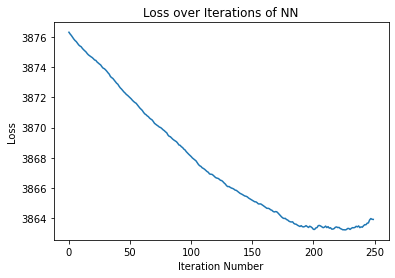

In [18]:
# Plot losses
plt.plot(loss_log)
plt.title("Loss over Iterations of NN")
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.show()

Look at that! As the epochs continue, we can see iterations show improvement in errors for the network. Important questions:
- What could prevent the error from continuously falling?
- What are some other good ideas for stopping rules for our algorithm? Or, how can we manipulate the learning rate?
- Instead of looking at average loss per batch, could you think of a better way to measure model performance?

## Overview of back propagation
So, after setting up the neural network, we need to:
- Calculate loss from the forward pass
- Calculate the gradient of random observations (SGD)
- Update weights by moving down the gradient with a step size specified by your learning rate
- Make new predictions with the new weights
- Repeat the these steps until you reach a stopping rule